In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from Perlin import perlin_np, perlin_pt, fractal_perlin_noise_pt

Using CUDA device: NVIDIA H100 PCIe

Generating single layer Perlin noise (256x256)...
  Done in 0.1139 seconds.
  Output range: [-0.641, 0.532]

Generating fractal Perlin noise (fBm) with default params (6 octaves, 256x256)...
  Done in 0.0113 seconds.
  Output range (normalized): [-1.000, 1.000]

Generating fractal Perlin noise (fBm) with detailed params (8 octaves, 256x256)...
  Done in 0.0058 seconds.
  Output range (normalized): [-1.000, 1.000]


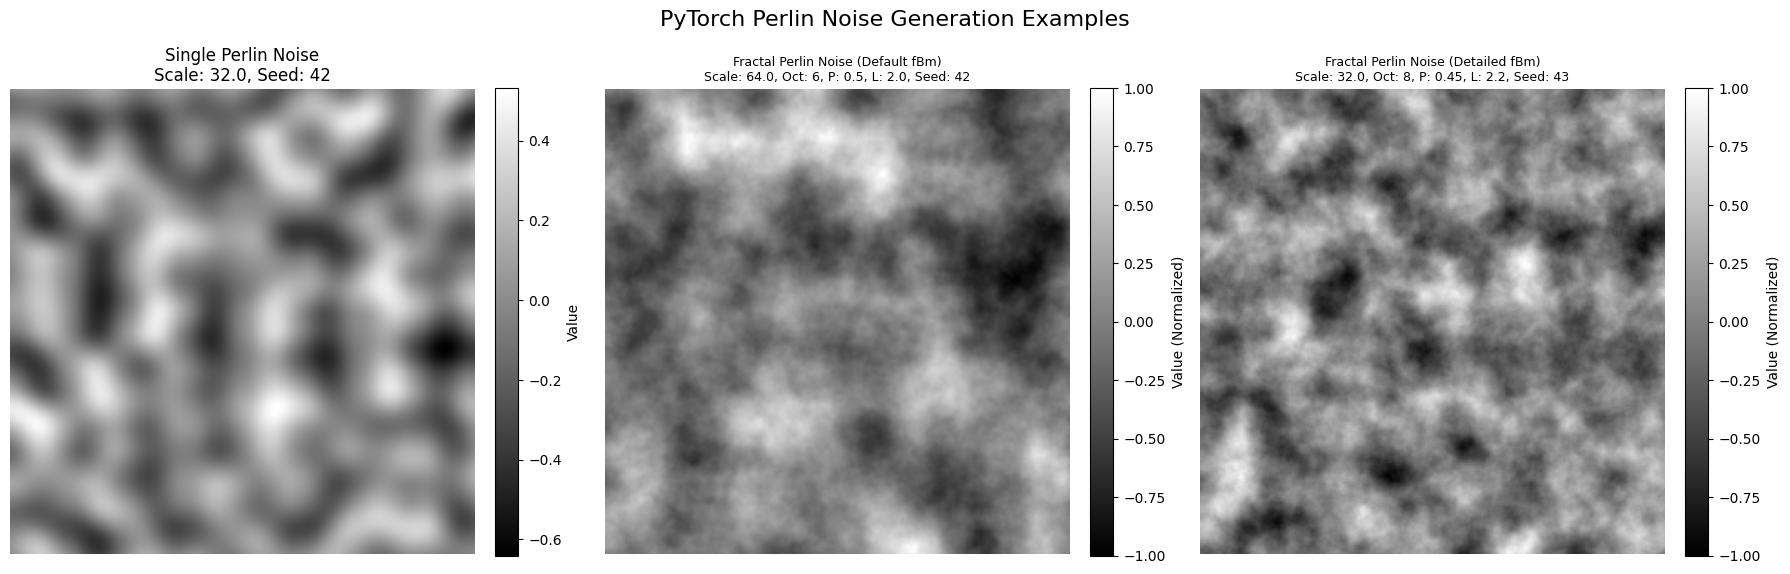

In [2]:
import torch
import matplotlib.pyplot as plt
import time # パフォーマンス計測用

# --- Test and Visualization ---
if __name__ == '__main__':
    H, W = 256, 256  # Output noise dimensions
    base_seed = 42   # Base seed for reproducibility
    
    # Determine device
    if torch.cuda.is_available():
        compute_device = torch.device("cuda")
        print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
    else:
        compute_device = torch.device("cpu")
        print("Using CPU device.")

    # 1. Test single layer Perlin noise (using perlin_pt directly)
    single_layer_scale = 32.0 # Controls the "zoom" level. Larger = more zoomed in.
    
    # Prepare coordinates for single layer perlin_pt
    x_single = torch.arange(W, device=compute_device, dtype=torch.float32) / single_layer_scale
    y_single = torch.arange(H, device=compute_device, dtype=torch.float32) / single_layer_scale
    y_mesh_single, x_mesh_single = torch.meshgrid(y_single, x_single, indexing='ij')
    r_coords_single = torch.stack([x_mesh_single, y_mesh_single])

    print(f"\nGenerating single layer Perlin noise ({H}x{W})...")
    start_time = time.time()
    noise_single_pt = perlin_pt(r_coords_single, seed=base_seed, device=compute_device)
    end_time = time.time()
    print(f"  Done in {end_time - start_time:.4f} seconds.")
    print(f"  Output range: [{noise_single_pt.min().item():.3f}, {noise_single_pt.max().item():.3f}]")


    # 2. Test Fractal Brownian Motion (fBm) noise
    fbm_params_default = {
        "shape": (H, W),
        "scale_factor": 64.0,   # Base feature size. Larger = bigger overall features.
        "octaves": 6,           # Number of noise layers
        "persistence": 0.5,     # How much each octave's amplitude decreases
        "lacunarity": 2.0,      # How much each octave's frequency increases
        "seed": base_seed,
        "device": compute_device,
        "normalize": True       # Output in [-1, 1]
    }
    
    print(f"\nGenerating fractal Perlin noise (fBm) with default params ({fbm_params_default['octaves']} octaves, {H}x{W})...")
    start_time = time.time()
    noise_fbm_default = fractal_perlin_noise_pt(**fbm_params_default)
    end_time = time.time()
    print(f"  Done in {end_time - start_time:.4f} seconds.")
    print(f"  Output range (normalized): [{noise_fbm_default.min().item():.3f}, {noise_fbm_default.max().item():.3f}]")


    # 3. Test fBm with different parameters for more detail
    fbm_params_detailed = {
        "shape": (H, W),
        "scale_factor": 32.0,   # Smaller base scale -> finer initial features
        "octaves": 8,           # More octaves for more detail
        "persistence": 0.45,    # Slightly less persistence for later octaves
        "lacunarity": 2.2,      # Higher lacunarity for faster frequency increase
        "seed": base_seed + 1,  # Different seed for a new pattern
        "device": compute_device,
        "normalize": True
    }
    print(f"\nGenerating fractal Perlin noise (fBm) with detailed params ({fbm_params_detailed['octaves']} octaves, {H}x{W})...")
    start_time = time.time()
    noise_fbm_detailed = fractal_perlin_noise_pt(**fbm_params_detailed)
    end_time = time.time()
    print(f"  Done in {end_time - start_time:.4f} seconds.")
    print(f"  Output range (normalized): [{noise_fbm_detailed.min().item():.3f}, {noise_fbm_detailed.max().item():.3f}]")


    # Plotting the results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot single layer Perlin noise
    im0 = axes[0].imshow(noise_single_pt.cpu().numpy(), cmap='gray')
    axes[0].set_title(f'Single Perlin Noise\nScale: {single_layer_scale}, Seed: {base_seed}')
    axes[0].axis('off')
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04, label="Value")

    # Plot default fBm noise
    im1 = axes[1].imshow(noise_fbm_default.cpu().numpy(), cmap='gray')
    title_fbm_default = (
        f'Fractal Perlin Noise (Default fBm)\n'
        f'Scale: {fbm_params_default["scale_factor"]}, Oct: {fbm_params_default["octaves"]}, '
        f'P: {fbm_params_default["persistence"]}, L: {fbm_params_default["lacunarity"]}, Seed: {fbm_params_default["seed"]}'
    )
    axes[1].set_title(title_fbm_default, fontsize=9)
    axes[1].axis('off')
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04, label="Value (Normalized)")
    
    # Plot detailed fBm noise
    im2 = axes[2].imshow(noise_fbm_detailed.cpu().numpy(), cmap='gray')
    title_fbm_detailed = (
        f'Fractal Perlin Noise (Detailed fBm)\n'
        f'Scale: {fbm_params_detailed["scale_factor"]}, Oct: {fbm_params_detailed["octaves"]}, '
        f'P: {fbm_params_detailed["persistence"]}, L: {fbm_params_detailed["lacunarity"]}, Seed: {fbm_params_detailed["seed"]}'
    )
    axes[2].set_title(title_fbm_detailed, fontsize=9)
    axes[2].axis('off')
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04, label="Value (Normalized)")
    
    plt.tight_layout()
    plt.suptitle("PyTorch Perlin Noise Generation Examples", fontsize=16, y=1.02)
    plt.show()